<a href="https://colab.research.google.com/github/linhkid/gdg-codelab-25/blob/main/search_tool/GDGC_Unleashing_Gemini_2.0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [ ]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [2]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [3]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [4]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [5]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [6]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the latest developments in quantum computing?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, with breakthroughs happening constantly. Here's a summary of some of the latest developments, categorized for clarity:

**1. Hardware Advancements (Building Better Qubits):**

*   **Improved Qubit Fidelity and Coherence:** A major focus is on creating qubits that are more stable (longer coherence times) and less prone to errors (higher fidelity). This involves:
    *   **Material Science:** Exploring new materials with lower defect densities for superconducting qubits and trapped ions.
    *   **Control Techniques:** Developing sophisticated pulse shaping and calibration methods to reduce control errors.
    *   **Error Mitigation:** Implementing algorithms to compensate for errors that inevitably occur during computation.
    *   **Hybrid Approaches:** Combining different types of qubits (e.g., superconducting and trapped ions) to leverage their individual strengths.
*   **Scalability:**  Moving beyond a few qubits to systems with hundreds or thousands of qubits. Key efforts include:
    *   **Modular Architectures:**  Connecting multiple smaller quantum processors to create larger, more powerful systems.
    *   **Quantum Interconnects:** Developing efficient and reliable ways to transfer quantum information between different qubit modules.
    *   **Cryogenic Engineering:** Designing advanced cooling systems to maintain qubits at extremely low temperatures.
*   **Qubit Modalities:** Research and development continue across various qubit modalities, each with its strengths and weaknesses:
    *   **Superconducting Qubits:** Leading in terms of qubit count, but face challenges in coherence and control.
    *   **Trapped Ions:**  Offer high fidelity and long coherence times, but scaling to larger systems is complex.
    *   **Photonic Qubits:**  Promising for quantum communication and potentially for building scalable quantum computers.
    *   **Neutral Atoms:**  Gaining traction as a potentially scalable and high-fidelity qubit technology.
    *   **Topological Qubits:**  A more futuristic approach that aims to create inherently stable qubits, resistant to decoherence.

**2. Software and Algorithms:**

*   **Quantum Error Correction:**  Developing codes that can detect and correct errors in quantum computations.  This is essential for building fault-tolerant quantum computers.  Progress is being made on both theoretical codes and their experimental implementation.
*   **Quantum Algorithm Development:**  Creating new quantum algorithms that can solve problems faster than classical algorithms. This includes:
    *   **Optimization Algorithms:**  Quantum Approximate Optimization Algorithm (QAOA) and Variational Quantum Eigensolver (VQE) are being actively researched and applied to various problems.
    *   **Quantum Machine Learning:** Exploring quantum algorithms for machine learning tasks, such as classification, clustering, and generative modeling.
    *   **Quantum Simulation:** Developing algorithms to simulate complex quantum systems, which has applications in materials science, drug discovery, and fundamental physics.
*   **Quantum Software Tools and Frameworks:**  Building software tools and frameworks that make it easier for researchers and developers to program and use quantum computers. Examples include:
    *   **Qiskit (IBM):**  A popular open-source SDK for working with quantum computers.
    *   **Cirq (Google):**  Another open-source framework for quantum programming.
    *   **PennyLane (Xanadu):**  A framework focused on differentiable quantum programming and quantum machine learning.
    *   **Braket (Amazon):**  A cloud-based quantum computing service that allows users to access different quantum hardware.

**3. Applications and Use Cases:**

*   **Drug Discovery and Materials Science:** Quantum computers are being used to simulate molecules and materials, which can accelerate the discovery of new drugs and materials with desired properties.
*   **Financial Modeling:** Exploring quantum algorithms for portfolio optimization, risk management, and fraud detection.
*   **Logistics and Supply Chain Optimization:** Applying quantum optimization algorithms to solve complex logistical problems, such as route planning and resource allocation.
*   **Cryptography:**  Developing quantum-resistant cryptographic algorithms to protect data from attacks by future quantum computers.  Also, exploring Quantum Key Distribution (QKD) for secure communication.
*   **Fundamental Research:** Using quantum computers to study fundamental physics, such as quantum gravity and the nature of dark matter.

**4. Key Trends and Recent News:**

*   **Increased Investment:**  Governments and private companies are investing heavily in quantum computing research and development, driving innovation and progress.
*   **Cloud-Based Quantum Computing:**  Cloud platforms are making quantum computers more accessible to researchers and developers, enabling them to experiment with quantum algorithms and applications.
*   **Emphasis on Error Mitigation:**  Researchers are increasingly focusing on developing techniques to mitigate errors in quantum computations, as this is crucial for achieving practical quantum advantage.
*   **Standardization Efforts:**  Organizations are working to develop standards for quantum computing hardware and software, which will help to promote interoperability and accelerate the development of the field.
*   **Quantum Supremacy/Advantage:** While the term "quantum supremacy" is debated, there's a continuing pursuit to demonstrate that quantum computers can solve specific problems that are intractable for even the most powerful classical computers.  These demonstrations are often narrow and not practically useful *yet*, but they are important milestones.

**Examples of Recent Developments (as of late 2023/early 2024):**

*   **IBM's Osprey and Condor processors:** IBM continues to push the boundaries of superconducting qubit technology with increasingly larger processors.  They are focusing on improving coherence and error rates alongside scaling.
*   **Google's advances in error correction:** Google is making significant strides in demonstrating the feasibility of quantum error correction.
*   **IonQ's Aria system:** IonQ continues to improve their trapped-ion systems, focusing on fidelity and connectivity.
*   **Quantum Key Distribution (QKD) networks:** Progress in building and deploying QKD networks for secure communication is ongoing.
*   **Advances in neutral atom qubit platforms:**  Several companies and research groups are making progress in scaling up neutral atom quantum computers.

**Challenges and Future Directions:**

Despite the significant progress, quantum computing still faces many challenges:

*   **Decoherence:** Maintaining the fragile quantum states of qubits is a major hurdle.
*   **Error Correction:** Implementing robust quantum error correction is essential for fault-tolerant quantum computing.
*   **Scalability:** Building quantum computers with thousands or millions of qubits is a significant engineering challenge.
*   **Algorithm Development:**  Finding new quantum algorithms that can provide a significant advantage over classical algorithms remains an active area of research.
*   **Software Development:**  Creating software tools and frameworks that make it easier to program and use quantum computers is crucial.

The future of quantum computing is bright, but it will require continued innovation and collaboration across various disciplines to overcome these challenges and unlock the full potential of this revolutionary technology.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


The latest developments in quantum computing include:

*   **Hardware Advancements:**
    *   **Hypercube network technologies:** Enhancing the scalability and performance of quantum systems by overcoming limitations in communication between qubits.
    *   **Integrated photonics:** Emerging as a promising avenue for scalable quantum computing with trapped ions, paving the way for more compact and efficient quantum devices.
    *   **Innovative materials:** Development of materials like germanium and GeSn-based quantum well lasers to improve quantum hardware efficiency and performance at nanoscale.
    *   **Topological Qubits:** Microsoft introduced the Majorana 1 chip in February 2024, the world's first quantum processor powered by topological qubits, representing a major step toward fault-tolerant quantum computing.
*   **Error Correction and Scalability:**
    *   **Logical Qubits:** Major quantum chip developers are shifting their focus from physical qubits to logical qubits, which use many imperfect qubits to encode an abstract "logical qubit" protected from errors.
    *   **Google's Willow processor:** Google claims its 105-qubit Willow quantum processor can perform a benchmark computation in under five minutes, a task that would take the world's second-fastest supercomputer 10 septillion years.
    *   **IBM's modular quantum computing:** IBM demonstrated two quantum processing units (QPUs) working in tandem and is working towards modular quantum computing, where multiple QPUs work together for scalable quantum computers.
*   **Quantum Machine Learning Integration:**
    *   Machine learning is increasingly integrated with quantum systems to enhance computational power, with frameworks like TorchQC enabling the application of deep learning techniques in quantum dynamics and control.
*   **Post-Quantum Cryptography:**
    *   Emphasis on developing post-quantum cryptographic algorithms to secure sensitive data against quantum threats, which is critical for safeguarding global communication networks.
*   **Networking Quantum Processors:**
    *   Companies are working on connecting multiple quantum computers to create a single virtual quantum computer with a higher qubit count. Photonic demonstrated distributed entanglement, linking qubits within separate quantum computers, and QuTech connected two small quantum computers in different cities.

Other key trends:

*   More experiments with logical qubits.
*   More specialized hardware/software.
*   More layers of software abstraction.
*   More workforce development tools.

As of 2025, there are around 100 to 200 quantum computers in use globally, and the number is expected to grow exponentially in the coming years.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context

In [7]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What are the top 3 electric vehicles with the longest range?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "How much do they cost?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "Compare their charging time"
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# # Visualize search usage across the conversation
# print("\n📊 Search Usage Visualization:")
# visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Based on the information from the provided search results, here are the top 3 electric vehicles with the longest range as of April 2025:

1.  **Lucid Air:** Up to 512 miles (Grand Touring model with 19-inch wheels)
2.  **Rivian R1T:** Up to 420 miles
3.  **Rivian R1S:** Up to 410 miles

It's worth noting that range can vary based on driving conditions, temperature, and other factors. Some sources also list the Mercedes-Benz EQS with a very long range, but the Lucid Air generally comes out on top in most comparisons.



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here's the approximate cost information for the top 3 EVs with the longest range:

1.  **Lucid Air:** Starting around \$71,400 for the base "Pure" trim and can reach upwards of \$250,500 for the high-performance "Sapphire" model.
2.  **Rivian R1T:** Starting around \$71,700 and can go up to \$101,700 depending on the trim and options.
3.  **Rivian R1S:** Starting around \$77,700 and can go up to \$107,700 depending on the trim and options.

It's important to note that these are starting prices, and the actual cost can vary significantly depending on the specific configuration, options, and any applicable incentives or discounts. Prices may also vary based on location and dealer.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging time'


Here's a comparison of the charging times for the Lucid Air, Rivian R1T, and Rivian R1S, considering both AC (home charging) and DC fast charging:

**Lucid Air**

*   **AC Charging (Home):** Using a 22 kW charger (if available), a full charge (0-100%) takes approximately 4.5 to 6 hours, depending on the battery size. With a typical 7kW home charging point it can take around 12 hours.
*   **DC Fast Charging:**
    *   The Lucid Air can accept up to 300 kW at DC fast-charging stations.
    *   At its peak charging rate, it can add up to 400 km (approximately 250 miles) of range in about 15 minutes.
    *   Charging from 10-80% can take as little as 22-26 minutes, depending on the specific Lucid Air model.

**Rivian R1T & R1S**

*   **AC Charging (Home):**
    *   Using a Level 2 (240V) charger, a full charge can take approximately 16-24 hours, depending on the battery pack size and charger amperage.
    *   With a 48-amp charger, you can add about 25 miles of range per hour, fully recharging in about 12 hours.
*   **DC Fast Charging:**
    *   The Rivian R1T and R1S support DC fast charging at speeds exceeding 200 kW, with some sources claiming future support for up to 300 kW.
    *   At over 200 kW, they can add up to 140 miles of range in about 20 minutes.
    *   Charging from 10-80% has been reported to take around 40-45 minutes.

**Summary Table (Estimates)**

| Charging Type        | Lucid Air                                  | Rivian R1T/R1S                           |
| -------------------- | ------------------------------------------ | ---------------------------------------- |
| AC (Home, Full Charge) | 4.5-6 hours (with 22kW) 12 hours (with 7kW) | 16-24 hours (with Level 2 charger)     |
| DC Fast (10-80%)     | 22-26 minutes (up to 300kW)               | 40-45 minutes (over 200kW)              |

**Important Considerations:**

*   **Charging Speed Factors:** Charging times can vary significantly based on factors such as the charger's output, the battery's current state of charge, battery temperature, and ambient temperature.
*   **Real-World Conditions:** The figures provided are estimates. Actual charging times may be longer or shorter depending on the specific circumstances.
*   **Software Updates:** Automakers sometimes release software updates that can improve charging speeds.



📊 Search Results Used:



# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [8]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)


print("#\n Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I will find the GDP growth rates for the world's top 5 economies for the most recent year, then generate Python code to create a Pandas DataFrame and a Matplotlib bar chart visualizing the data.



Based on the search results, here are the GDP growth rates for the world's top 5 economies for 2024 and/or forecasts for 2025. Note that different sources have slightly varying figures. I will use the most recent and specific figures where available.

**Top 5 Economies and their GDP Growth Rates:**

1.  **United States:**
    *   2024: 2.4% (Q4 over previous quarter) (Trading Economics) or 2.8% (for full year) (Trading Economics) or 2.6% (Euromonitor Q4 2024)
    *   2025: 2.2% (OECD, March 2025)

2.  **China:**
    *   2024: 4.9% (World Bank, Dec 2024) or 4.8% (IMF, Oct 2024)
    *   2025: 4.1% (World Bank) or 4.4% (OECD, March 2025)

3.  **Germany:**
    *   2024: Eu area 0.8% (World Economic Outlook, October 2024)
    *   2025: 1.0% (OECD, March 2025)

4.  **Japan:**
    *   2024: 0.3% (IMF, Oct 2024)
    *   2025: 1.1% (Forbes India)

5.  **India:**
    *   2024/25 (Financial Year): 7% (World Bank, Sept 2024)
    *   2025: 6.5% (IMF) or 7% (World Bank)

I'll use the latest available full-year estimates or forecasts for 2024/2025 in the code below: US (2.8% - 2024), China (4.9% - 2024), Germany (0.8%-2024), Japan (0.3% - 2024), India (7% - 2024/25)



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for the top 5 economies' GDP growth rates
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate (%)': [2.8, 4.9, 0.8, 0.3, 7.0]}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate for better visualization
df = df.sort_values(by='GDP Growth Rate (%)', ascending=False)

# Define colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Example colors, can be customized

# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate (%)'], color=colors)

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024/2025)', fontsize=14)
plt.ylim(0, 8)  # Set Y-axis limit for better visualization

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--')

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()
```



The code first defines the data in a dictionary, then creates a Pandas DataFrame.  It sorts the data by GDP growth rate, selects visually appealing colors, and generates a bar chart using Matplotlib. The chart includes labels, a title, value labels on each bar, rotated x-axis labels, and grid lines for enhanced readability.  The y-axis limit is set, and the layout is adjusted to prevent overlapping labels. Finally, the plot is displayed. This code should run directly in a Jupyter Notebook and produce the requested visualization.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


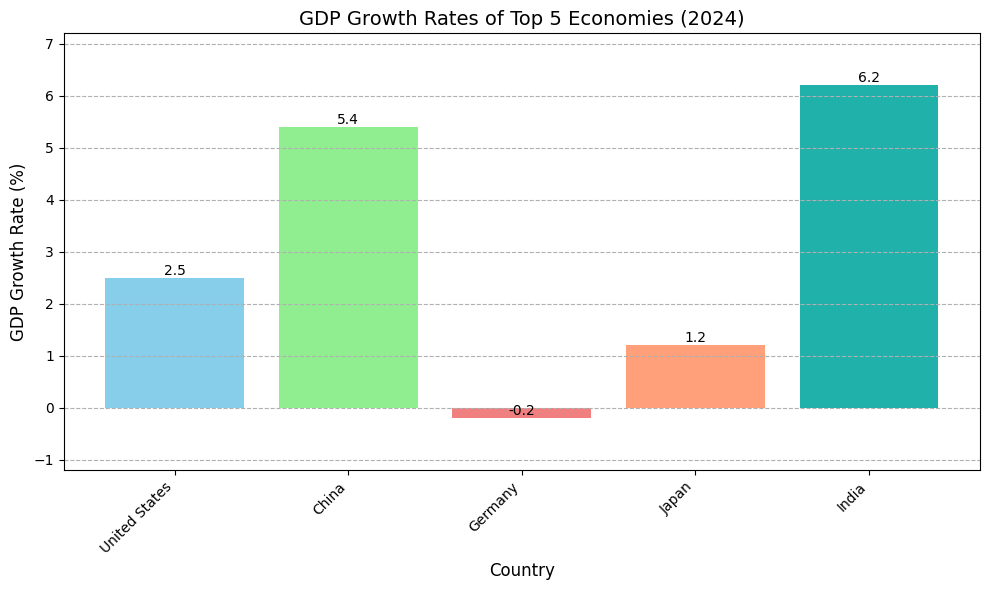

In [9]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving pexels-photo-2071882.jpeg to pexels-photo-2071882.jpeg
Uploaded image:


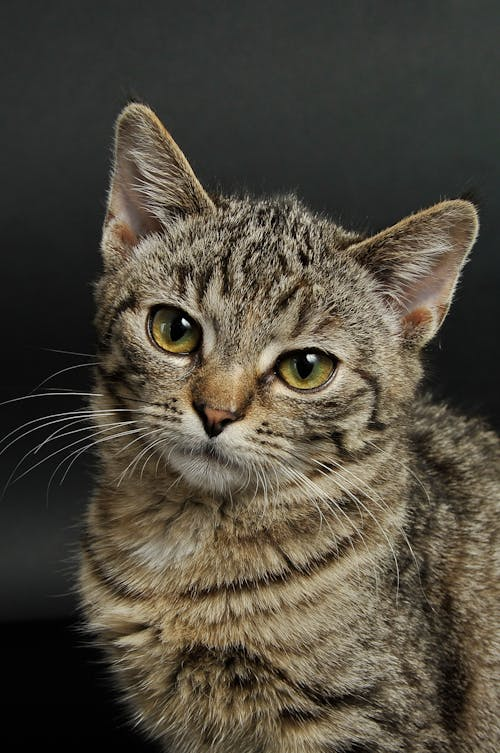


🔍 Analyzing image...


Here is the information about the image:

Main Subject: Cat

Description: A brown tabby cat with green eyes is pictured against a dark background.



🔍 Searching for detailed information...


Here's some detailed information about tabby cats, based on the search results:

*   **What is a Tabby Cat?** Tabby is not a breed of cat, but rather a coat pattern that can appear in many different breeds. The tabby pattern is very common amongst non-pedigree cats around the world. All domestic cats are genetically tabbies.
*   **Origin and History:**
    *   The tabby pattern dates back to domestic cats in ancient Egypt.
    *   The term "tabby" originally referred to "striped silk taffeta". The English term comes from the French word "tabis," meaning "a rich watered silk." This can be traced further to the Middle French "atabis" (14th century), stemming from the Arabic term referring to the Attabiya district of Baghdad, noted for its striped cloth and silk.
    *   The use of "tabby cat" for a cat with a striped coat began in the 1690s.
*   **Tabby Patterns:** There are five main tabby patterns:
    *   **Mackerel (striped):**  Has long, narrow, parallel stripes. It resembles a fish skeleton. This is believed to be the original tabby coat pattern.
    *   **Classic (blotched):** Features wider, curved stripes with swirls, sometimes resembling a target.
    *   **Spotted:** Has spots instead of stripes.
    *   **Ticked (agouti):**  Individual hairs have alternating bands of light and dark color. Ticked tabbies don't have the usual stripes or spots, but do have tabby markings on the face.
    *   **Patched:** Features patches of tabby markings, usually on calico or tortoiseshell cats. These are referred to as caliby and torbie, respectively.
*   **The "M" Marking:** Tabby cats typically have a distinct "M" marking on their forehead. There are a few legends associated with this marking:
    *   One legend is that Mary, the mother of Jesus, placed her initial on a tabby cat's forehead to thank it for keeping the baby Jesus warm.
    *   Another legend states that Prophet Muhammad had a tabby cat that saved him from a poisonous snake, and he blessed the cat with the letter "M" on its forehead.
    *   In ancient Egypt, tabby cats were believed to have a strong relationship with the moon, and the "M" is a mark of that relationship.
*   **Interesting Facts:**
    *   Tabby cats come in various colors, including brown, gray, orange, and black.
    *   Orange tabby cats are more commonly male (about 80% are male).
    *   Tabby cats are known for being affectionate, intelligent, playful, curious, and excellent hunters.



📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): Mèo tabby khác gì giống Mèo Anh lông ngắn ?

🔍 Searching for answer to: 'Mèo tabby khác gì giống Mèo Anh lông ngắn ?'


Mèo Tabby (mèo mướp) và mèo Anh lông ngắn (ALN) là hai khái niệm khác nhau:

*   **Mèo Tabby**: Không phải là một giống mèo cụ thể. "Tabby" chỉ đơn giản là một kiểu hoa văn lông phổ biến, đặc trưng bởi các sọc, vằn hoặc đốm trên nền lông. Mèo Tabby có thể thuộc nhiều giống mèo khác nhau. Tất cả mèo nhà đều có gen Tabby.
*   **Mèo Anh lông ngắn**: Là một giống mèo có nguồn gốc từ Anh, được biết đến với thân hình tròn trịa, lông ngắn, dày và khuôn mặt tròn trịa.

**Điểm khác biệt chính:**

*   **Giống vs. Hoa văn:** Mèo ALN là một giống mèo riêng biệt, còn "tabby" là một kiểu hoa văn lông có thể xuất hiện ở nhiều giống khác nhau. Mèo ALN có thể có hoa văn tabby, khi đó chúng được gọi là mèo ALN tabby.
*   **Nguồn gốc:** Mèo ALN có nguồn gốc từ Anh. Hoa văn tabby xuất hiện từ thời mèo Ai Cập cổ đại.
*   **Ngoại hình:** Mèo ALN có những đặc điểm riêng về hình dáng cơ thể, cấu trúc xương và loại lông. Mèo Tabby có thể có nhiều hình dáng và kích cỡ khác nhau tùy thuộc vào giống mèo.

**Tóm lại:**
Một con mèo ALN có thể có hoa văn tabby, hoặc không. Nếu một con mèo ALN có hoa văn tabby, nó sẽ được gọi là mèo ALN tabby. Nói cách khác, mèo ALN tabby là một nhánh nhỏ của giống mèo ALN, được phân biệt bởi hoa văn lông của chúng.



📊 Search Results Used:


In [18]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from google.genai.types import HttpOptions, Part
from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return image_file.read()

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    image_bytes = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""

    What is shown in this image? Please identify the main subject and provide a brief description in format below: \n
    Main Subject: subject \n
    Description: description \n
    """

    print("\n🔍 Analyzing image...")

    multimodal_chat.send_message([Part.from_bytes(data=image_bytes, mime_type="image/jpeg")])
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [11]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


Based on the current information, here's an analysis of the electric vehicle (EV) market in Europe:

**Current State & Market Share:**

*   **Overall Trend:** The European EV market, encompassing both battery electric vehicles (BEVs) and plug-in hybrid electric vehicles (PHEVs), experienced a slight contraction in 2024 compared to 2023. Total EV registrations reached over 2.96 million units, a decrease of 1.8% year-on-year.
*   **BEV Dominance:** BEVs constitute the majority of the EV market, accounting for 67.7% of all plug-in registrations in 2024, slightly up from 2023. PHEVs held 32.3% market share, experiencing a sharper decline than BEVs.
*   **Market Share:**
    *   For the full year 2024, BEVs accounted for 15.4% of the total European new car market (EU, EFTA, UK), down slightly from 15.7% in 2023. In the EU specifically, the BEV market share was 13.6% in 2024.
    *   Combined BEV and PHEV market share averaged 22% in Europe in 2024, down one percentage point from 2023.
    *   Data from early 2025 suggests a potential rebound, with BEV market share in the EU reaching 15.2% in the first two months, driven by strong growth in Germany, Belgium, and the Netherlands.
    *   Hybrid electric vehicles (HEVs) are showing strong growth, capturing 35.2% of the EU market in early 2025 and remaining a preferred choice for consumers. In September 2024, HEVs (34% share) outsold petrol cars (29% share) for the first time.
    *   Traditional petrol and diesel car sales continue to decline, holding a combined 38.8% share in early 2025, down from 48.5% a year prior.

**Major Players & Top Sellers:**

*   **Manufacturer Groups:**
    *   **Volkswagen Group:** Remained the top seller of BEVs in Europe in 2024 with over 427,000 units registered, although its BEV market share slightly decreased to 21.5% from 22.2% in 2023.
    *   **Tesla:** Secured the second position in BEV sales despite increased competition and a decline in deliveries (-10.4% year-on-year). Tesla was the top-selling EV *brand* overall (BEV + PHEV) for the third year running in 2024, with 328,036 deliveries, holding an 11.1% share of the plug-in market.
    *   **BMW Group:** Secured second place in overall EV (BEV + PHEV) sales in 2024 with 292,407 registrations (+10.7% YoY), holding a 9.9% market share.
    *   **Mercedes-Benz:** Took third place in overall EV sales with 258,677 registrations (+10% YoY) and an 8.7% market share.
    *   **Volvo:** Showed significant growth, finishing fourth in overall EV sales with 239,255 deliveries (+42% YoY) and an 8.1% share.
    *   **Stellantis:** Remained in the top three BEV producers despite a 10% drop in volume.
*   **Top Selling Models (2024 data):**
    *   **BEVs:** The Tesla Model Y was the best-selling BEV in Europe in 2024 (210,504 units), despite a drop in sales compared to 2023. The Tesla Model 3 also performed strongly. The Volvo EX30 became Europe's third best-selling BEV after its introduction. Other notable models included the Skoda Enyaq, VW ID.7, MG 4, and Audi Q4 e-tron.
    *   **PHEVs:** The Volvo XC60 was the best-selling PHEV in Europe in 2024 (58,662 units), followed by the Ford Kuga and Mercedes-Benz GLC.
    *   **Overall Best Seller:** The Dacia Sandero (primarily internal combustion engine, but indicating affordability trends) overtook the Tesla Model Y to become Europe's best-selling car model overall in 2024.

**Growth Trends & Outlook:**

*   **Slowdown in 2024:** After years of rapid growth (+107% in 2019-20, +63% in 2020-21, +29% in 2021-22, +28% in 2022-23), BEV sales saw a year-on-year decline of 1.2% in 2024. This slowdown was particularly influenced by the phase-out of subsidies in Germany, a major market.
*   **Shift towards Hybrids:** Hybrid cars (HEVs) were the only segment showing significant year-on-year growth (+21% in 2024), driven largely by Toyota/Lexus and Renault Group.
*   **Resurgence in Late 2024/Early 2025?:** Some data points suggest a return to growth. September 2024 saw a 6% YoY increase in plug-in registrations (BEVs +14%, PHEVs -9%). January and February 2025 showed strong BEV growth (+28.4% YoY for the two months combined in the EU), although this compares to a low base in early 2024.
*   **Influence of Chinese Brands:** Cars manufactured in China are gaining significant market share, becoming the sixth-largest country of origin for new cars registered in Europe in 2024, surpassing Japan, the UK, and Turkey. Brands like MG and Geely (including Volvo) are contributing to this trend.
*   **Future Projections:**
    *   Analysts project modest growth for European EV sales in 2024/2025, potentially reaching 3.5 million units in 2024 (around 10% growth YoY). EVs are expected to represent about one in four cars sold.
    *   Stronger growth is anticipated from 2025 onwards, partly driven by stricter EU CO2 regulations kicking in.
    *   Carmakers are planning to launch more affordable, mass-market EV models made in Europe in the coming years.
    *   Long-term estimates suggest EV sales share could reach 85-95% by 2035.
*   **Challenges:** The market faces challenges including the reduction or removal of subsidies in some countries (like Germany), higher upfront costs compared to ICE vehicles (though average EV prices rose significantly between 2021 and early 2024), and varying charging infrastructure development across nations.

In summary, the European EV market is navigating a period of adjustment after rapid expansion. While 2024 saw a slight dip, particularly in BEV sales and influenced by subsidy changes, underlying growth continues in many countries. Hybrids are gaining popularity, competition is increasing (notably from Chinese brands), and major players like VW Group, Tesla, BMW, and Mercedes-Benz lead the charge. The outlook remains positive, especially from 2025, driven by regulations and the expected arrival of more affordable models.


📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow


In [12]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the research stages
    # print("\n📊 Research Stage Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


Okay, let's break down the intersection of Quantum Machine Learning (QML) and Drug Discovery.



Okay, here is a broad overview of Quantum Machine Learning (QML) for Drug Discovery:

**Broad Overview: Quantum Machine Learning for Drug Discovery**

Quantum Machine Learning (QML) sits at the intersection of quantum computing and machine learning, aiming to leverage the principles of quantum mechanics (like superposition and entanglement) to potentially enhance or accelerate machine learning tasks. In the context of drug discovery, which is traditionally a very long, expensive, and high-failure-rate process, QML holds the promise of revolutionizing various stages by tackling complex computational problems currently intractable for classical computers.

**1. Main Concepts and Terminology**

*   **Quantum Computing (QC):** Uses quantum bits (qubits) which can exist in multiple states simultaneously (superposition) and can be linked (entanglement), allowing for potentially massive parallelism and different types of computation compared to classical bits (0s and 1s).
*   **Machine Learning (ML):** Algorithms that allow computers to learn from data to make predictions or decisions without being explicitly programmed for the task (e.g., analyzing patterns, classification, regression).
*   **Quantum Machine Learning (QML):** The integration of QC and ML. This can mean using quantum algorithms to speed up ML tasks, using ML to analyze quantum systems, or developing entirely new hybrid quantum-classical algorithms.
*   **Drug Discovery Pipeline:** The multi-stage process including:
    *   **Target Identification:** Finding biological molecules (like proteins) involved in a disease.
    *   **Hit Identification:** Screening large libraries of compounds to find those that interact with the target ('hits').
    *   **Lead Optimization:** Modifying hits to improve efficacy, safety, and pharmacokinetic properties (ADMET - Absorption, Distribution, Metabolism, Excretion, Toxicity).
    *   **Preclinical & Clinical Trials:** Testing safety and efficacy.
*   **Key QML Algorithms/Concepts in Drug Discovery:**
    *   **Quantum Simulators:** Using quantum computers to accurately model molecular interactions, potentially predicting properties like binding affinity more accurately than classical methods.
    *   **Quantum Neural Networks (QNNs):** Quantum analogues of classical neural networks.
    *   **Quantum Support Vector Machines (QSVMs):** Quantum version of SVMs for classification tasks.
    *   **Variational Quantum Algorithms (VQAs):** Hybrid algorithms (like VQE - Variational Quantum Eigensolver) where a quantum computer prepares and measures a state based on parameters optimized by a classical computer. Often used for molecular energy calculations.
    *   **Quantum Generative Models (e.g., qGANs):** Using quantum systems to generate novel molecular structures with desired properties.
    *   **Hybrid Quantum-Classical Approaches:** Combining classical computers for data storage and some processing with quantum computers for specific computationally hard sub-tasks. This is the dominant approach currently due to hardware limitations.
    *   **Data Encoding:** A crucial challenge involving how to represent classical data (like molecular structures or properties) efficiently on a quantum computer.

**2. Current State of Development**

*   **Nascent Stage:** QML for drug discovery is still in its very early stages of research and development. Practical applications delivering real-world drugs are not yet realized.
*   **NISQ Era Dominance:** Current quantum computers are Noisy Intermediate-Scale Quantum (NISQ) devices, meaning they have a limited number of qubits and are susceptible to errors (noise). This restricts the size and complexity of problems that can be tackled.
*   **Focus on Hybrid Models:** Due to NISQ limitations, most current work involves hybrid quantum-classical approaches, leveraging the strengths of both systems.
*   **Proof-of-Concept:** Many studies focus on demonstrating the *potential* of QML algorithms on small molecules or simplified problems, often using quantum simulators running on classical hardware.
*   **Algorithm Development:** Significant effort is going into designing QML algorithms that are suitable for NISQ hardware and relevant drug discovery tasks (e.g., molecular property prediction, generative chemistry).
*   **Hardware Limitations:** Progress is heavily dependent on advancements in quantum hardware (more qubits, lower error rates, better connectivity).

**3. Key Players or Contributors**

*   **Quantum Hardware/Software Providers:** IBM Quantum, Google Quantum AI, D-Wave Systems, Rigetti Computing, IonQ, Quantinuum (merger of Honeywell Quantum Solutions and Cambridge Quantum), Xanadu, Pasqal, Atos.
*   **Specialized QML/Software Companies:** Zapata Computing, SandboxAQ, QC Ware, ProteinQure, Polaris Quantum Biotech, Menten AI, Qubit Pharmaceuticals. These often focus on developing algorithms and platforms specifically for chemistry and life sciences.
*   **Pharmaceutical Companies:** Many large pharma companies (e.g., Roche, Merck KGaA, Boehringer Ingelheim, GSK, Amgen, Moderna, Japan Tobacco) are actively exploring QML, often through partnerships with quantum computing companies or research institutions.
*   **Academic Institutions:** Numerous universities worldwide are conducting fundamental research in QML and its applications.
*   **Cloud Platforms:** Providers like AWS (Amazon Braket), Microsoft (Azure Quantum) offer access to various quantum hardware and simulators.
*   **Technology Companies:** Companies like NVIDIA are developing platforms (e.g., CUDA-Q) to simulate quantum systems on classical high-performance computers, accelerating QML research.

**4. Recent Major Developments (Conceptual & Research-Focused)**

*   **Improved Hybrid Algorithms:** Refinements in variational algorithms (VQEs, QAOA) and error mitigation techniques make them slightly more practical on NISQ devices.
*   **Focus on Specific Tasks:** Increased research targeting specific drug discovery bottlenecks, such as predicting molecular properties (e.g., binding affinity), simulating molecular dynamics, and generating novel drug-like molecules using quantum generative models.
*   **Quantum-Enhanced Generative AI:** Exploration of using quantum or quantum-hybrid methods to enhance Large Language Models (LLMs) or other generative AI for creating novel molecular structures, sometimes showing improved "drug-likeness" compared to purely classical methods in proof-of-concept studies.
*   **Benchmarking Efforts:** Attempts to compare QML approaches against state-of-the-art classical ML methods on relevant drug discovery tasks, although often on limited datasets or problem sizes. Current findings often suggest hybrid approaches are recommended for now.
*   **Platform Development:** Continued development of software libraries and platforms (e.g., PennyLane, Qiskit, CUDA-Q, Strawberry Fields) designed to facilitate QML research and application development, integrating with classical ML frameworks like PyTorch and TensorFlow.
*   **Increased Collaborations:** A growing number of partnerships between quantum technology providers and pharmaceutical companies to explore specific use cases.

---

**Interesting Subtopics for Further In-Depth Exploration:**

Based on the current state and potential impact, here are 3-5 subtopics ripe for deeper investigation:

1.  **Hybrid Quantum-Classical Algorithms for Molecular Property Prediction:**
    *   *Why Interesting:* This is currently the most practical approach. Understanding *how* VQAs (like VQE) or quantum kernel methods are combined with classical optimizers to predict properties like binding affinity or toxicity is crucial.
    *   *Exploration:* Investigate specific hybrid workflows, the types of properties they target, the challenges in parameter optimization, and comparisons with purely classical ML methods on relevant benchmarks.

2.  **Quantum Generative Models for De Novo Drug Design:**
    *   *Why Interesting:* Generating entirely novel molecular structures with desired properties is a key goal in drug discovery. Quantum systems might explore chemical space differently or more effectively than classical generative models (GANs, VAEs).
    *   *Exploration:* Delve into how quantum circuits (e.g., Quantum Circuit Born Machines, qGANs) can be trained to learn distributions of molecules and generate new candidates. What are the challenges in representing molecules and ensuring the generation of valid, synthesizable structures?

3.  **Quantum Simulation for Accurate Molecular Modeling:**
    *   *Why Interesting:* Accurately simulating quantum interactions within molecules (especially larger ones or those with complex electron correlation) is classically very difficult but fundamental to understanding drug action. Quantum computers are naturally suited for this.
    *   *Exploration:* Focus on algorithms beyond simple VQEs, like Quantum Phase Estimation (though fault-tolerant), and how they promise higher accuracy for calculating ground state energies, excited states, or reaction dynamics relevant to drug binding and mechanism of action. What are the resource requirements (qubit count, coherence time) for simulating pharmaceutically relevant molecules?

4.  **Data Encoding Strategies for Chemical Data:**
    *   *Why Interesting:* A fundamental bottleneck is how to effectively represent complex chemical information (graphs, sequences, 3D structures, large feature vectors like fingerprints) using a limited number of qubits. The encoding method drastically impacts algorithm performance.
    *   *Exploration:* Investigate different quantum feature maps, amplitude encoding, basis encoding, and other techniques used for cheminformatics data. How do they handle the high dimensionality and specific structures (like molecular graphs) common in drug discovery? What are the trade-offs between encoding efficiency and expressivity?

5.  **Error Mitigation Techniques in QML for Drug Discovery:**
    *   *Why Interesting:* NISQ devices are noisy, and errors severely limit computational accuracy. Understanding and applying error mitigation strategies is essential for getting meaningful results from near-term quantum hardware.
    *   *Exploration:* Study techniques like zero-noise extrapolation, probabilistic error cancellation, and error suppression methods. How are they specifically applied within QML algorithms used for drug discovery tasks, and how effective are they in improving result quality on real hardware?

These subtopics cover a mix of algorithmic approaches, specific applications, and fundamental challenges within the field of QML for drug discovery.


📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are three subtopics extracted from the previous discussion, identified as particularly valuable for further exploration in Quantum Machine Learning for Drug Discovery:

---

**1. Subtopic: Hybrid Quantum-Classical Algorithms for Molecular Property Prediction**

*   **Significance:** This area is arguably the most pragmatic and actively researched for near-term impact. Classical ML already plays a significant role in predicting properties like binding affinity, solubility, and toxicity (ADMET). However, accurately capturing the underlying quantum mechanical interactions governing these properties remains challenging for classical methods, especially for complex molecules. Hybrid approaches aim to delegate the computationally hard quantum parts (e.g., calculating electronic structure features) to a quantum processor while leveraging classical computers for data handling, optimization, and integrating other features. Success here could directly accelerate the lead optimization phase by providing faster and potentially more accurate predictions than classical methods alone.
*   **Aspects Needing Deeper Research:**
    *   **Optimal Quantum Feature Extraction:** Identifying which specific molecular information is best calculated on a quantum computer and how to effectively represent these quantum-derived features for classical ML models.
    *   **Scalability:** Determining how these hybrid models scale with molecule size and complexity, given current and near-future (NISQ) hardware limitations (qubit count, connectivity, noise).
    *   **Benchmarking:** Rigorous comparison against state-of-the-art *classical* ML methods on diverse, relevant drug discovery datasets to demonstrate genuine quantum advantage.
    *   **Integration:** Developing robust frameworks and workflows for seamlessly integrating quantum computations (often from cloud platforms or specialized hardware) into existing classical drug discovery pipelines.
    *   **Noise Resilience:** Investigating the impact of hardware noise on the quality of quantum-derived features and the effectiveness of error mitigation techniques within these specific hybrid workflows.

---

**2. Subtopic: Quantum Generative Models for De Novo Drug Design**

*   **Significance:** Generating novel molecular structures with specific desired properties (*de novo* design) is a "holy grail" of drug discovery. While classical generative AI (GANs, VAEs, Transformers) has made strides, exploring the vast chemical space efficiently and generating truly novel, diverse, and synthesizable candidates remains difficult. Quantum generative models (like qGANs or Quantum Circuit Born Machines) theoretically offer new ways to learn complex probability distributions representing chemical space and potentially generate molecules inaccessible or overlooked by classical algorithms, possibly leveraging quantum superposition to explore possibilities more broadly.
*   **Aspects Needing Deeper Research:**
    *   **Molecular Representation:** Developing effective ways to encode and represent molecular structures (graphs, strings, 3D coordinates) within quantum generative frameworks.
    *   **Constraint Handling:** Ensuring generated molecules adhere to chemical validity rules (valency, etc.) and optimizing for multiple properties simultaneously (e.g., high affinity, low toxicity, good synthesizability) within the quantum generation process.
    *   **Trainability and Scalability:** Understanding the challenges in training these quantum models (e.g., barren plateaus) and how their requirements scale with the complexity of the desired chemical space.
    *   **Novelty and Diversity:** Quantifying whether quantum generative models produce genuinely novel and diverse chemical scaffolds compared to leading classical methods.
    *   **Hybrid Generation:** Exploring hybrid quantum-classical generative approaches where quantum components might assist in specific aspects like scaffold hopping or fragment assembly.

---

**3. Subtopic: Quantum Simulation for Accurate Molecular Modeling (Direct & VQE-based)**

*   **Significance:** At its core, drug action is governed by quantum mechanical interactions between a drug molecule and its biological target (e.g., a protein). Classical computational chemistry methods often rely on approximations that limit their accuracy, especially for large systems or those with strong electron correlation effects. Quantum computers promise to simulate these systems with much higher fidelity. While full simulation requires fault-tolerant machines, near-term algorithms like the Variational Quantum Eigensolver (VQE) – often used *within* hybrid ML approaches (see Subtopic 1) – allow for approximate calculations of molecular energies and properties on NISQ devices. Improving these simulations is fundamental to understanding *why* drugs work and designing better ones based on first principles.
*   **Aspects Needing Deeper Research:**
    *   **Accuracy vs. Resource Trade-offs:** Evaluating the accuracy achievable with NISQ algorithms (like VQE) for pharmaceutically relevant calculations (e.g., relative binding energies) compared to classical methods, considering the required quantum resources (qubits, gate depth, coherence time).
    *   **Algorithm Development for NISQ:** Designing more efficient and noise-resilient quantum algorithms (beyond basic VQE) for specific chemical simulation tasks relevant to drug discovery (e.g., calculating excited states, reaction barriers).
    *   **Active Space Selection:** Developing methods to intelligently select the most critical part of a large molecule (the active space) for high-accuracy quantum simulation while treating the rest classically.
    *   **Embedding Theories:** Improving quantum embedding techniques (combining high-level quantum calculations on a fragment with lower-level classical methods for the environment) suitable for drug-protein interactions.
    *   **Path to Fault Tolerance:** Understanding the specific resource requirements (logical qubits, T-gates) for achieving chemically accurate simulations of drug-sized molecules using future fault-tolerant quantum computers and algorithms like Quantum Phase Estimation (QPE).

---


📊 Stage 3: Deep dive into first subtopic


Okay, let's perform a deep dive into the subtopic: **Hybrid Quantum-Classical Algorithms for Molecular Property Prediction**.

This area represents one of the most promising near-term applications of quantum computing in drug discovery, leveraging the strengths of both computational paradigms.

**Deep Dive: Hybrid Quantum-Classical Algorithms for Molecular Property Prediction**

**1. Latest Research Findings or Developments**

*   **Dominance of Hybrid Models:** Current research overwhelmingly focuses on hybrid models due to the limitations of Noisy Intermediate-Scale Quantum (NISQ) hardware. Purely quantum algorithms large enough for complex property prediction are not yet feasible.
*   **Variational Quantum Eigensolver (VQE) as a Core Component:** VQE is frequently used as the quantum part of the hybrid loop. It aims to find the ground state energy of a molecule, which is a fundamental property linked to stability and reactivity. This energy or related electronic structure information (like electron density or orbitals) can then be used as a feature input into a classical machine learning model.
    *   *Example:* Research often involves calculating the VQE-derived energy for a series of related molecules (conformations or analogues) and correlating this with experimentally known properties like binding affinity using classical regression models (e.g., Support Vector Regression, Neural Networks).
*   **Quantum Kernel Methods:** Another popular approach involves using quantum computers to estimate kernel functions ("quantum kernels"). Molecular data (e.g., molecular fingerprints) is encoded into a quantum state, and the similarity between these states (the kernel entry) is calculated. This quantum kernel can then be plugged into classical kernel methods like Support Vector Machines (SVMs) for classification (e.g., predicting toxicity) or regression.
    *   *Example:* Studies published via platforms like *arXiv* often demonstrate using quantum kernel SVMs to classify molecules as active/inactive against a target or toxic/non-toxic, typically on small, curated datasets like QM9 or specific subsets relevant to a disease target. Performance varies significantly based on the data encoding and kernel choice.
*   **Focus on Specific Properties:** Research is targeting key drug discovery properties:
    *   **Binding Affinity:** Predicting how strongly a drug candidate binds to its target protein. Hybrid models might use VQE to calculate interaction energies or specific quantum features of the binding pocket or ligand.
    *   **ADMET Properties:** Absorption, Distribution, Metabolism, Excretion, Toxicity. Quantum kernel methods are often explored for classifying toxicity or predicting solubility.
    *   **Reaction Prediction/Stability:** Using VQE-calculated energies to assess molecular stability or predict reaction pathways relevant to synthesis or metabolism.
*   **Integration with Classical ML Frameworks:** Significant effort is going into integrating quantum components (accessed via cloud or simulators) into standard ML pipelines using libraries like PyTorch or TensorFlow, facilitated by platforms like PennyLane (Xanadu) and Qiskit (IBM).
*   **Benchmarking & Error Mitigation:** Recent work increasingly includes applying error mitigation techniques (e.g., Zero-Noise Extrapolation, symmetry verification) to VQE calculations on real NISQ hardware and comparing results (often on small molecules like H2, LiH, or small organic molecules) against classical computational chemistry methods (like DFT) and purely classical ML models.

**2. Key Challenges or Controversies**

*   **Demonstrating Quantum Advantage:** The most significant challenge and point of controversy. To date, there's limited concrete evidence that current hybrid quantum-classical algorithms *consistently* outperform state-of-the-art *classical* ML or physics-based methods for *realistic* drug discovery property prediction tasks on relevant datasets. Many proof-of-concept studies show promise but often use small molecules or datasets where classical methods already perform well or where the quantum advantage isn't clear-cut.
*   **Scalability:** NISQ hardware limitations (qubit count, coherence times, connectivity, noise levels) severely restrict the size and complexity of molecules that can be handled by the quantum component (e.g., VQE calculations are often limited to very small active spaces). Scaling these methods to drug-sized molecules interacting with proteins remains a major hurdle.
*   **Data Encoding:** Efficiently and effectively encoding classical molecular data (which can be high-dimensional, like fingerprints or complex graphs) onto qubits is non-trivial. The choice of encoding strategy dramatically impacts the performance of methods like quantum kernels.
*   **Noise:** NISQ devices are inherently noisy. Errors accumulate quickly, corrupting the results of quantum calculations (like VQE energies or kernel estimations). While error mitigation helps, it adds computational overhead and doesn't eliminate errors entirely.
*   **Ansatz Design for VQE:** The performance of VQE heavily depends on the choice of the variational *ansatz* (the parameterized quantum circuit). Designing ansatze that are expressive enough to capture the true ground state, trainable (avoiding barren plateaus), and hardware-efficient (shallow depth, respecting qubit connectivity) is difficult.
*   **Integration Complexity:** Seamlessly integrating noisy quantum computations (often run asynchronously on cloud platforms) with classical optimization loops and ML models presents significant software engineering and workflow challenges.

**3. Notable Innovations or Breakthroughs**

*   **Hardware-Aware Algorithms:** Development of algorithms and compilation techniques specifically designed to minimize noise and gate counts on particular quantum hardware architectures.
*   **Advanced Error Mitigation Protocols:** Progress in developing and applying more sophisticated error mitigation techniques beyond simple post-selection or readout correction, tailored for chemical simulations (e.g., leveraging physical symmetries).
*   **Specialized Software Platforms:** The maturation of platforms like PennyLane, Qiskit Nature, TensorFlow Quantum, and Amazon Braket, which provide tools specifically designed to facilitate the construction and testing of hybrid quantum-classical workflows for chemistry and ML.
*   **Quantum Kernel Engineering:** Research into designing quantum kernels that are better suited for specific types of chemical data or learning tasks, including methods for optimizing the kernel itself.
*   **Successful Proof-of-Concepts (Specific Cases):** While general quantum advantage isn't proven, specific studies have shown hybrid methods matching or slightly improving upon classical baselines for *very specific*, often simplified, property prediction tasks on small molecules, demonstrating the potential feasibility of the approach. *Citation Example: Often found in publications from collaborations between quantum providers and pharma/chemical companies presented at conferences like Q2B or in journals like JCIM/JPCL.*
*   **Quantum-Inspired Classical Algorithms:** Insights gained from designing quantum algorithms (especially tensor networks) have sometimes led to improved *classical* algorithms for simulating quantum systems or performing ML tasks, blurring the lines of "quantum advantage". SandboxAQ, for instance, highlights this synergy.

**4. Future Directions and Potential Impacts**

*   **Scaling Quantum Components:** The primary direction is leveraging expected improvements in quantum hardware (more qubits, lower noise, better connectivity, eventually fault tolerance) to handle larger, more relevant molecular systems within the quantum part of the hybrid model.
*   **Beyond Ground State Energy:** Using quantum components to calculate more complex properties directly relevant to drug action, such as excited states (for photochemistry), transition states (for reaction kinetics), or properties requiring accurate electron correlation.
*   **Achieving Demonstrable Advantage:** Focusing research on carefully chosen problems where quantum mechanics plays a crucial role and where classical methods genuinely struggle, aiming to provide clear evidence of quantum advantage on industrially relevant benchmarks.
*   **Tighter Integration with AI:** Seamlessly embedding quantum feature generation or quantum kernel calculations within larger AI-driven drug discovery platforms, potentially enabling closed-loop systems where properties are predicted and molecules are iteratively redesigned.
*   **Reduced Reliance on Experimental Data:** If hybrid models become sufficiently accurate and reliable, they could significantly reduce the need for expensive and time-consuming wet-lab experiments during the lead optimization phase, drastically cutting costs and timelines.
*   **Personalized Medicine:** In the longer term, highly accurate property predictions could contribute to designing drugs tailored to individual genetic profiles or specific disease subtypes.

**5. Leading Experts, Organizations, or Companies**

*   **Quantum Hardware/Cloud Providers:**
    *   **IBM Quantum:** Actively researching chemical simulations and ML with Qiskit, numerous pharma collaborations.
    *   **Google Quantum AI:** Research in algorithms (like QAOA, QML) and hardware, TensorFlow Quantum library.
    *   **Quantinuum:** Trapped-ion hardware, focus on chemical simulations, partnerships (e.g., with Mitsui).
    *   **IonQ:** Trapped-ion hardware, collaborations in materials science and exploring life sciences.
    *   **Amazon Braket / Microsoft Azure Quantum:** Cloud platforms providing access to various hardware types and simulators, fostering ecosystem development.
    *   **Pasqal / Xanadu / Rigetti:** Other hardware providers actively exploring chemical/ML applications.
*   **Specialized Quantum Software/Algorithm Companies:**
    *   **Zapata Computing:** Focus on enterprise solutions, hybrid algorithms, Orquestra platform.
    *   **SandboxAQ:** Spun off from Alphabet, focuses on AQ (AI+Quantum), including simulation and QML for drug discovery and materials, leveraging tensor networks.
    *   **QC Ware:** Develops quantum algorithms for enterprise, including chemistry and ML applications.
    *   **Xanadu:** Develops PennyLane (popular QML library) and photonic quantum hardware.
    *   **ProteinQure:** Specifically focused on using quantum/ML for protein-based drug design.
*   **Pharmaceutical/Chemical Companies (Exploratory/Partnerships):**
    *   Roche, Merck KGaA (e.g., partnership with Quantinuum/HQS), Boehringer Ingelheim (partnership with Google), GSK, Amgen, BASF, Dow, Mitsubishi Chemical, JSR Corporation, and many others are actively exploring QML via internal teams or partnerships.
*   **Academic Research Groups:** Numerous universities globally have strong research groups in quantum computing, quantum chemistry, and machine learning. Key figures include Alán Aspuru-Guzik (U. Toronto), Matthias Troyer (Microsoft), Frank Leymann (U. Stuttgart), Garnet Chan (Caltech), and many others contributing significantly to algorithm development and application. *Specific expert names can be readily found by searching recent review articles and key publications in the field.*

In summary, hybrid quantum-classical algorithms for molecular property prediction represent a vibrant but challenging area. While still in the early stages and facing significant hurdles related to hardware limitations and demonstrating clear advantage, ongoing innovations in algorithms, hardware, and software platforms suggest it remains a key pathway for potentially realizing the impact of quantum computation on accelerating drug discovery.


📊 Stage 4: Synthesizing insights and recommendations


Okay, here is an executive brief synthesizing our research on Quantum Machine Learning (QML) for Drug Discovery, aimed at informing strategic decision-making.

---

**Executive Brief: Quantum Machine Learning (QML) in Drug Discovery**

**Introduction:**
Quantum Machine Learning represents a potential paradigm shift for drug discovery, aiming to leverage quantum computing principles to tackle complex calculations currently intractable for classical machines. While holding significant long-term promise for accelerating timelines and improving success rates, the field is currently in a nascent stage, characterized by rapid research, hardware evolution, and the exploration of near-term hybrid approaches.

**1. Major Insights:**

*   **Nascent but Promising Field:** QML for drug discovery is largely developmental, constrained by current Noisy Intermediate-Scale Quantum (NISQ) hardware limitations (qubit count, noise). Its true impact hinges on significant future advancements in quantum computing power and error correction.
*   **Hybrid Models Dominate Near-Term:** The most practical and actively researched area today involves Hybrid Quantum-Classical algorithms. These leverage quantum processors for specific, computationally hard sub-tasks (like calculating molecular energies via VQE or evaluating quantum kernels) while relying on classical computers for data processing, optimization, and overall workflow control. Molecular property prediction is a primary target.
*   **Quantum Advantage Remains Elusive:** Demonstrating clear, practical "quantum advantage" – where QML methods unequivocally outperform the best classical algorithms (including advanced AI/ML) on relevant drug discovery problems and datasets – is the most critical unmet challenge. Current proof-of-concepts often use simplified models or small molecules.
*   **Ecosystem Collaboration is Key:** Progress is driven by a collaborative ecosystem involving quantum hardware providers (IBM, Google, Quantinuum, etc.), specialized software/algorithm firms (Zapata, SandboxAQ, Xanadu, etc.), pharmaceutical companies exploring use cases (Roche, Merck KGaA, Boehringer Ingelheim, etc.), and academic research institutions.

**2. Emerging Trends and Patterns:**

*   **Focus on Specific Use Cases:** A shift from general QML exploration towards targeting specific, high-value bottlenecks in the drug discovery pipeline, such as accurate binding affinity prediction, ADMET property modeling, and *de novo* molecular design using quantum generative models.
*   **Increased Benchmarking Rigor:** Growing emphasis on comparing hybrid QML approaches against state-of-the-art classical computational chemistry and machine learning methods on standardized, albeit often still small, datasets.
*   **Platform Integration:** Development of software libraries (e.g., PennyLane, Qiskit) and cloud platforms (AWS Braket, Azure Quantum) aimed at integrating quantum components more seamlessly into classical computational chemistry and AI/ML workflows.
*   **Hardware-Aware Algorithm Design:** Increasing focus on designing algorithms (e.g., VQE ansatze) and employing error mitigation techniques specifically tailored to the constraints and error characteristics of current NISQ hardware.

**3. Gaps and Contradictions:**

*   **Scalability Gap:** A significant gap exists between the small molecular systems currently tractable on NISQ hardware and the larger, more complex systems (e.g., drug-protein interactions) relevant for industrial drug discovery.
*   **Proof vs. Potential:** There's a potential contradiction between the considerable hype and investment surrounding QML's *potential* and the current lack of widely accepted, reproducible demonstrations of practical quantum advantage in this domain.
*   **Optimal Problem Selection:** Uncertainty remains regarding which specific problems within drug discovery will genuinely benefit most significantly (and soonest) from quantum computation versus continued advancements in classical HPC and AI.
*   **Standardization:** Lack of standardized benchmarks and reporting makes direct comparison between different QML studies and approaches difficult.

**4. Recommendations for Practical Application / Strategic Positioning:**

*   **Invest in Quantum Readiness:** Build internal understanding and expertise in quantum computing fundamentals and QML concepts. Monitor the field actively, focusing on hardware progress and algorithm breakthroughs.
*   **Targeted Exploration via Hybrid Models:** Initiate pilot projects using hybrid quantum-classical approaches, focusing on specific, well-defined problems where quantum effects are expected to be significant and where classical methods face known limitations (e.g., predicting properties for molecules with complex electronic structures).
*   **Strategic Partnerships:** Engage in collaborations with quantum technology providers and/or academic experts to leverage external expertise and gain access to cutting-edge hardware and software, co-developing solutions for relevant use cases.
*   **Focus on Integration:** Plan for the potential future integration of quantum components into existing computational drug discovery platforms and workflows. Assess data representation and software compatibility challenges early.
*   **Maintain Classical Excellence:** Continue investing in and leveraging state-of-the-art classical computational chemistry and AI/ML methods, as these remain the workhorses of drug discovery and the benchmark against which QML must prove its value.

**5. Suggested Directions for Future Research:**

*   **Scalable & Noise-Resilient Algorithms:** Develop QML algorithms (especially for simulation and property prediction) that are inherently more scalable and robust to noise, potentially reducing reliance on perfect fault-tolerant hardware.
*   **Quantum Advantage Benchmarks:** Establish standardized, complex, and industrially relevant benchmark problems specifically designed to rigorously test and demonstrate potential quantum advantage over best-in-class classical methods.
*   **Chemical Data Encoding:** Innovate more efficient and chemically meaningful ways to represent complex molecular structures and properties on quantum computers.
*   **Error Correction & Mitigation:** Continue advancing error mitigation techniques for NISQ devices and push towards practical implementations of quantum error correction relevant for chemical simulations.
*   **Resource Estimation:** Develop better tools for accurately predicting the quantum hardware resources (qubits, coherence time, gate fidelity) required to solve specific, impactful drug discovery problems.

**Conclusion:**
QML holds transformative potential for drug discovery but requires a long-term perspective. Strategic engagement today involves building internal readiness, exploring near-term hybrid approaches through targeted pilots and partnerships, and closely monitoring hardware and algorithmic advancements, while continuously comparing potential benefits against powerful existing classical techniques. The key is to be prepared to leverage breakthroughs as they occur, rather than expecting immediate widespread impact.


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [13]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the analysis stages
    # print("\n📊 Competitive Analysis Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Okay, I will conduct a comprehensive analysis of Rivian, focusing on the areas you've specified. Here's how I'll approach it:

1.  **Company Overview:** I'll start with a brief history of Rivian, its size (employee count if available), and its key product offerings.
2.  **Market Position and Share:** I'll investigate Rivian's current standing in the EV market and try to find specific market share data.
3.  **Financial Performance:** I'll look into recent financial reports to identify performance metrics and growth trends.
4.  **Key Executives:** I will find out who are the key executives, and note any recent leadership changes.
5.  **Strategic Moves:** I'll search for recent acquisitions, partnerships, and new product launches.



Here's an analysis of Rivian, incorporating the information I found:

**1. Company Overview:**

*   **History:** Rivian Automotive, Inc. was founded in 2009 by Robert "RJ" Scaringe in Rockledge, Florida. Initially, the company focused on autonomous and electric vehicles under the names Mainstream Motors and Avera Automotive before settling on Rivian Automotive in 2011.
*   **Size:** As of December 2023, Rivian had 16,790 employees.
*   **Key Offerings:** Rivian designs and manufactures electric vehicles, including:
    *   R1T: A two-row, five-passenger electric pickup truck (deliveries started in late 2021).
    *   R1S: A three-row, seven-passenger electric SUV.
    *   EDV: Electric Delivery Van (for commercial customers, particularly Amazon).
*   **Facilities:** Headquartered in Irvine, California. Manufacturing plant in Normal, Illinois. Other facilities in Palo Alto and Carson, California; Plymouth, Michigan; Burnaby, British Columbia; Wittmann, Arizona; Woking, England; and Belgrade, Serbia. A new US$5 billion factory is planned for Georgia.

**2. Current Market Position and Market Share:**

*   **Market Position:** Rivian is an American EV manufacturer, designing, manufacturing, and selling electric vehicles and commercial delivery vans. They are positioned as a competitor to established brands in the EV space, targeting outdoor enthusiasts.
*   **Market Share:**
    *   In Q1 2025, the U.S. EV market share was 7.5% of all new car sales, up from 7.0% in Q1 2024, but down from 8.7% in Q4 2024.
    *   Rivian Q1 EV market share topped 5% as of April 2024
    *   Tesla's U.S. EV market share was 43.4% in Q1 2025, although sales were down 9% year-over-year.

**3. Recent Financial Performance and Growth Trends:**

*   **Revenue:**
    *   Q4 2024 revenue was $1.73 billion, up 31.9% year-over-year, exceeding analyst estimates by 22.4%. Automotive revenue reached $1.5 billion, including regulatory credit sales.
    *   2023 revenue was US$4.43 billion.
    *   Rivian's annualized revenue growth over the last two years is 73.1%.
*   **Profitability:**
    *   Rivian achieved a positive gross margin in Q4 2024. Gross profit was $170 million in Q4 2024. Automotive segment-level gross profit was $110 million (7% gross margin). Software and services revenue was $214 million, with a gross profit of $60 million (28% gross margin).
    *   Net losses persist. Q4 2024 net loss was $744 million, compared to $1100 million in the previous quarter.
    *   Adjusted EBITDA loss for Q4 2024 was $277 million, an improvement year-over-year.
    *   The company expects modest gross profit for the full year 2025 and an adjusted EBITDA loss between $1.7 and $1.9 billion.
*   **Cash Flow:**
    *   Rivian's Net Operating Cash Flow is -$1,716 million, and Free Cash Flow is -$2,857 million.
    *   Cash equivalents and short-term investments increased to $7.7 billion as of December 31, 2024.
*   **Vehicle Production & Deliveries:**
    *   In Q4 2024, Rivian produced 12,727 vehicles and delivered 14,183 vehicles.
    *   For the full year 2024, Rivian produced 49,476 vehicles and delivered 51,579 vehicles.
*   **Cost Reduction:**
    *   Rivian reduced automotive cost of goods sold by $31,000 per vehicle year-over-year in Q4 2024.
*   **Analyst Forecasts:**
    *   Analysts expect revenue to decline by 2.4% over the next 12 months.
    *   Rivian is forecast to grow earnings and revenue by 15.9% and 29.1% per annum respectively.

**4. Key Executives and Leadership Changes:**

*   **RJ Scaringe:** Founder and CEO.  Assumed direct responsibility for all product functions, including Software, Autonomy, Design, Vehicle, Electrical, Propulsion, and Programs (as of late 2023). Serves as Chairman of the Board for "Also, Inc."
*   **Nick Kalayjian:** Formerly Chief Product Officer, now Executive Vice President of Vehicle Engineering and Propulsion.
*   **Richard Farquhar:** Formerly VP of Propulsion, now Senior Vice President of R&D.
*   **Kjell Gruner:** Resigned as Chief Commercial Officer and President of Business Growth in July 2024. He remained employed with Rivian until February 17, 2025, to assist with the transition.
*   **Dagan Mishoulam:** Promoted to Senior Vice President, Commercial, assuming many of Gruner's responsibilities.
*   **Jennifer Prenner:** Hired to lead marketing efforts in 2024.
*   **Javier Varela:** Appointed COO in May 2024, succeeding Frank Klein.
*   **Jeffrey Baker:** Resigned as Chief Accounting Officer. Claire McDonough (CFO) is serving as interim principal accounting officer.
*   **Sreela Venkataratnam:** Added as CAO.

**5. Recent Strategic Moves:**

*   **Volkswagen Group Partnership:**
    *   In June 2024, Volkswagen Group announced its intention to invest up to $5 billion in Rivian, with an initial $1 billion investment.
    *   Rivian and Volkswagen Group launched a $5.8 billion joint venture to develop advanced software and electrical systems for EVs. The joint venture is co-led by Rivian Chief Software Officer Wassym Bensaid and Volkswagen Group Chief Technology Officer Carsten Helbing.
    *   The first vehicle using the joint venture's technology is expected by 2027.
*   **Spin-off of Micromobility Unit:**
    *   Rivian spun off its micromobility business into a new startup named "Also," focused on small, lightweight electric vehicles.
    *   "Also" secured a $105 million investment from Eclipse Ventures. Rivian remains a minority shareholder, and RJ Scaringe will serve as Chairman of the Board. First product launch is expected in early 2026.
*   **New Vehicle Models:**
    *   Rivian unveiled the R2 SUV (starting from $45,000) and the R3 (costing even less) in March 2024. R2 is expected to launch in 2026.
*   **DOE Loan:**
    *   Rivian closed a loan agreement with the U.S. Department of Energy's (DOE) Loan Programs Office (LPO) for up to $6.6 billion to support the construction of its manufacturing facility in Georgia.
*   **Technology and Software:**
    *   Rivian is focusing on developing software for its own vehicles and VW's, leveraging its hardware designs, electrical systems, and integrated platform powered by Amazon Web Services (AWS) and Databricks.
    *   Rivian is simplifying vehicle electronics. Its second-generation R1 vehicles reduced the number of electronic control units (ECUs) from 17 to just seven.
*   **Charging Network:**
    *   Rivian planned to build an exclusive charging network in the United States and Canada by the end of 2023.
*   **Adoption of NACS:**
    *   Rivian announced plans to adopt Tesla's charging standard (NACS).

This analysis provides a comprehensive overview of Rivian's current state, highlighting its strengths, weaknesses, and strategic direction within the competitive electric vehicle manufacturing industry.



📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Okay, I will identify Rivian's top 3-5 direct competitors and then provide a structured comparison based on the criteria you've outlined.

Here are Rivian's top competitors, based on product overlap (electric trucks, SUVs, and commercial vans) and market aspirations:

*   Tesla
*   Ford (especially its electric truck and SUV offerings)
*   General Motors (GMC Hummer EV, Chevrolet Silverado EV)
*   Lucid Motors (positioned as a luxury EV manufacturer)

Now, here's the structured comparison:

**Competitor Comparison: Rivian**

| Feature                     | Rivian                                                                                                                                                                                  | Tesla                                                                                                                                                                                                                                         | Ford                                                                                                                                                                                                  | General Motors (GMC/Chevy)                                                                                                                                                                                           | Lucid Motors                                                                                                                                                                            |
| --------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Company Overview**     | Founded in 2009, focuses on electric adventure vehicles (trucks and SUVs) and commercial vans.                                                                                           | Founded in 2003, the leading EV manufacturer globally, also involved in energy generation and storage.                                                                                                                                   | Established automaker with a long history. Now aggressively moving into EVs.                                                                                                                   | One of the world's largest automakers, with a growing line of electric vehicles.                                                                                                                                    | Founded in 2007, focuses on luxury electric vehicles with a focus on technology and performance.                                                                         |
| **2. Market Share & Position** | Niche player, targeting outdoor enthusiasts. Growing but still small market share in the EV segment. Gaining recognition for its R1T and R1S.                                              | Dominant market share leader in the EV market worldwide. High brand recognition and customer loyalty.                                                                                                                                     | Transitioning to EVs, aiming for a significant share of the electric truck and SUV market. Leveraging its existing customer base and dealer network.                                                 | Expanding into EVs with the Hummer EV and Silverado EV, targeting different segments. Leveraging established manufacturing and dealer network.                                                                                 | Niche player in the luxury EV segment. Focused on high-end vehicles.                                                                                                 |
| **3. Key Differentiators & Advantages** | Adventure-focused brand, unique design, "tank turn" capability, innovative storage solutions, strong focus on sustainability. Amazon partnership provides a strong commercial van customer.                                                                      | Brand recognition, Supercharger network, advanced technology (Autopilot), vertical integration (battery production).                                                                                                   | Established brand, large dealer network, manufacturing expertise, economies of scale, strong presence in the truck market.                                                                                             | Extensive manufacturing capabilities, diverse vehicle portfolio, strong brand recognition, and Ultium battery platform.                                                                                                | Focus on luxury, long range, fast charging, sophisticated design, and advanced technology.                                                                                    |
| **4. Recent Strategic Moves** | Partnership with Volkswagen, unveiled R2 and R3 models, secured DOE loan, spun off micromobility unit ("Also").                                                                       | Expanding Gigafactories globally, developing new battery technology, pushing for full self-driving, entering new markets (e.g., India).                                                                                                      | Scaling up EV production (F-150 Lightning, Mustang Mach-E), investing in battery production, forming strategic partnerships (e.g., SK Innovation).                                                              | Launching new EV models (Hummer EV SUV, Blazer EV, Equinox EV, Silverado EV), investing in battery production (Ultium), and developing Cruise (autonomous driving).                                                        | Focusing on Lucid Gravity SUV launch, expanding manufacturing capacity, and entering international markets.                                                                      |
| **5. Strengths vs. Rivian**   | **Tesla:** Scale, brand recognition, charging infrastructure. **Ford:** Manufacturing, dealer network, customer loyalty, truck expertise. **GM:** Scale, Ultium platform, vehicle range. **Lucid:** Luxury positioning, range, technology. | **Rivian:** Adventure-focused brand, innovative features, Amazon partnership, strong design identity.                                                                                                                                | **Tesla:** Higher production volume, established Supercharger network, better economies of scale. **Ford:** Wider market reach through extensive dealer network, more affordable options. **GM:** Broad range of EVs, established infrastructure. **Lucid:** Luxury appeal, longer range. | **Tesla:** Niche market, relies on new technology. **Ford:** Higher price, lacks brand recognition. **GM:** Higher price, niche market. **Lucid:** Manufacturing and supply chain issues, limited brand recognition. |

**Summary of Strengths and Weaknesses Relative to Rivian**

*   **Tesla:** Stronger brand, far larger production capacity, and a well-established Supercharger network. Weakness is not being solely focused on Adventure vehicles.
*   **Ford:** Enormous production capacity and a huge dealer network. Weakness is the brand is not focused on adventure vehicles.
*   **General Motors:** Huge manufacturing capacity, extensive range of EV models, and the Ultium battery platform. The weakness is the brand is not focused on adventure vehicles.
*   **Lucid Motors:** Appeals to luxury buyers and offers long-range vehicles. Weaknesses: lower production numbers, higher price points, and limited brand recognition compared to Rivian.

This comparative analysis should provide a good understanding of Rivian's competitive landscape and how it stacks up against its major rivals.



📊 Stage 3: SWOT analysis for Rivian


Okay, I will conduct a detailed SWOT analysis for Rivian based on the information gathered so far.

Here's the SWOT analysis:

**Rivian SWOT Analysis**

**1. Strengths (Internal Advantages and Capabilities):**

*   **Adventure-Focused Brand & Design:** Rivian has carved out a unique brand identity centered on adventure and the outdoors, differentiating it from mainstream EV manufacturers. The design of the R1T and R1S is distinctive and appeals to a specific customer base.
    *   *Explanation:* This unique branding attracts customers seeking vehicles for outdoor activities and lifestyles.
*   **Innovative Features & Technology:** Rivian vehicles have innovative features, like the "tank turn" (on some models), gear tunnel, and integrated camping solutions. Their focus on software and over-the-air updates keeps the vehicles current and enhances the ownership experience.
    *   *Explanation:* These features create buzz and set Rivian apart from traditional SUVs and trucks.
*   **Amazon Partnership:** The partnership with Amazon provides a guaranteed customer for Rivian's Electric Delivery Van (EDV). This provides stable revenue and helps scale production.
    *   *Explanation:* Provides a large initial order and allows for real-world testing and refinement of the EDV platform.
*   **Strong Engineering & Design Talent:** Rivian has assembled a skilled team of engineers and designers who have experience in both automotive and technology sectors.
    *   *Explanation:* This expertise is crucial for developing innovative vehicles and overcoming the technical challenges of EV manufacturing.
*   **Positive Gross Margin (Recent):** Achieving a positive gross margin in Q4 2024 is a significant step towards profitability and demonstrates improving production efficiency.
    *   *Explanation:* Indicates Rivian is getting better at controlling manufacturing costs and pricing its vehicles competitively.

**2. Weaknesses (Internal Disadvantages or Limitations):**

*   **Limited Production Capacity & Scaling Challenges:** Rivian is still in the early stages of scaling production. Its production capacity is limited compared to established automakers, and it has faced challenges in ramping up output.
    *   *Explanation:* Constrained production limits revenue growth and delays deliveries, potentially frustrating customers.
*   **Negative Profitability & Cash Burn:** Despite recent gross margin improvements, Rivian is still losing money and burning through cash. It needs to reach higher production volumes and reduce costs to achieve profitability.
    *   *Explanation:* This reliance on external funding makes Rivian vulnerable to changes in market conditions and investor sentiment.
*   **Relatively High Vehicle Prices:** Rivian's vehicles are priced higher than some competing electric trucks and SUVs, potentially limiting its market reach.
    *   *Explanation:* Makes it harder to compete with more affordable EVs from established manufacturers.
*   **Limited Brand Awareness (Compared to Established Automakers):** Rivian is a relatively new brand, and its brand awareness is lower than that of established automakers like Ford, GM, and Tesla.
    *   *Explanation:* Requires significant marketing investment to build brand recognition and attract customers.
*   **Supply Chain Vulnerabilities:** Like other automakers, Rivian is susceptible to supply chain disruptions, especially in the sourcing of battery components and semiconductors.
    *   *Explanation:* Can lead to production delays and increased costs.

**3. Opportunities (External Factors that Could Benefit the Company):**

*   **Growing Demand for Electric Vehicles:** The global demand for electric vehicles is growing rapidly, creating a large market opportunity for Rivian.
    *   *Explanation:* Provides a favorable environment for Rivian to increase sales and market share.
*   **Government Incentives & Regulations:** Government incentives and regulations that promote the adoption of EVs can benefit Rivian.
    *   *Explanation:* Subsidies, tax credits, and emissions standards can increase demand for Rivian's vehicles.
*   **Expansion into New Markets:** Rivian has the opportunity to expand into new geographic markets, particularly in Europe and Asia, to further increase sales.
    *   *Explanation:* Diversifying its geographic footprint reduces reliance on the North American market.
*   **Development of New Vehicle Models & Services:** Rivian can expand its product portfolio by developing new vehicle models (e.g., more affordable SUVs) and offering new services (e.g., charging solutions, subscription services).
    *   *Explanation:* Broadening its offerings can attract new customers and increase revenue streams.
*   **Strategic Partnerships & Collaborations:** Collaborating with other companies in areas such as battery technology, charging infrastructure, and autonomous driving can accelerate Rivian's development and expand its capabilities. The Volkswagen partnership is a prime example.
    *   *Explanation:* Sharing resources and expertise can reduce costs and improve competitiveness.

**4. Threats (External Factors that Could Negatively Impact the Company):**

*   **Intense Competition:** The electric vehicle market is becoming increasingly competitive, with established automakers and new entrants vying for market share.
    *   *Explanation:* Makes it harder for Rivian to differentiate itself and attract customers.
*   **Economic Downturn:** An economic downturn could reduce consumer spending and decrease demand for electric vehicles, particularly high-priced models.
    *   *Explanation:* Could negatively impact Rivian's sales and profitability.
*   **Rising Raw Material Costs:** Rising costs for raw materials, such as lithium and nickel, could increase the cost of manufacturing electric vehicles, putting pressure on Rivian's margins.
    *   *Explanation:* Makes it harder to price vehicles competitively and achieve profitability.
*   **Technological Disruption:** Rapid advancements in battery technology and autonomous driving could make Rivian's technology obsolete.
    *   *Explanation:* Requires continuous investment in R&D to stay competitive.
*   **Regulatory Changes:** Changes in government regulations related to electric vehicles could negatively impact Rivian.
    *   *Explanation:* Examples include changes to tax credits or emissions standards.

This SWOT analysis provides a comprehensive overview of Rivian's internal strengths and weaknesses, as well as the external opportunities and threats it faces in the electric vehicle market.



📊 Stage 4: Strategic recommendations


Okay, based on the competitive intelligence gathered, here are actionable strategic recommendations for Rivian, structured to address its strengths, weaknesses, opportunities, and threats:

**Strategic Recommendations for Rivian Executives**

**1. Leveraging Strengths:**

*   **Recommendation 1.1: Deepen the Adventure Brand Experience:**
    *   *Action:* Expand Rivian's brand beyond just vehicles. Develop branded adventure gear, partner with outdoor retailers and experience providers (e.g., guided off-road tours), and create Rivian-exclusive adventure destinations/charging hubs.
    *   *Rationale:* Capitalizes on Rivian's unique brand identity, fosters customer loyalty, and generates additional revenue streams.
*   **Recommendation 1.2: Enhance Software and Connectivity Services:**
    *   *Action:* Develop and offer a suite of value-added software services such as enhanced navigation, off-road route planning, vehicle monitoring, and over-the-air performance upgrades. Explore subscription models for these services.
    *   *Rationale:* Leverages Rivian's tech-savviness to create recurring revenue, improve the customer experience, and differentiate from competitors.
*   **Recommendation 1.3: Optimize the Amazon Partnership for Scalability:**
    *   *Action:* Work closely with Amazon to optimize the EDV design and manufacturing processes for even greater efficiency. Leverage Amazon's logistics expertise to streamline Rivian's supply chain and delivery operations.
    *   *Rationale:* Maximizes the benefits of the Amazon contract, drives down EDV costs, and improves overall operational efficiency.
*   **Recommendation 1.4: Continuously Improve Manufacturing Efficiency:**
    *   *Action:* Aggressively pursue cost reductions in manufacturing through improved automation, optimized supply chain management, and value engineering.
    *   *Rationale:* Strengthens financial performance and better positions Rivian for competition in the broader EV market.

**2. Addressing or Mitigating Weaknesses:**

*   **Recommendation 2.1: Secure Additional Funding and Improve Financial Stability:**
    *   *Action:* Continue to explore partnerships with strategic investors to secure additional funding. Develop a detailed plan to achieve profitability, focusing on cost reduction and revenue growth.
    *   *Rationale:* Reduces financial risk and provides capital for growth initiatives.
*   **Recommendation 2.2: Accelerate Production Ramp-Up:**
    *   *Action:* Invest aggressively in expanding production capacity at the Normal, Illinois, plant. Streamline manufacturing processes to increase output and reduce bottlenecks. Prioritize the launch and ramp of R2 production at the Georgia plant.
    *   *Rationale:* Increases revenue, reduces per-vehicle costs, and fulfills customer demand more quickly.
*   **Recommendation 2.3: Expand Vehicle Lineup with More Affordable Models:**
    *   *Action:* Prioritize the launch of the R2 and R3 models, ensuring competitive pricing to attract a broader customer base.
    *   *Rationale:* Increases market reach and competitiveness by offering more accessible EV options.
*   **Recommendation 2.4: Invest in Brand Building and Awareness:**
    *   *Action:* Launch targeted marketing campaigns to increase brand awareness and consideration. Highlight Rivian's unique value proposition and adventure-focused brand identity.
    *   *Rationale:* Attracts new customers and builds brand loyalty.
*   **Recommendation 2.5: Diversify Supply Chain and Secure Key Component Sourcing:**
    *   *Action:* Establish relationships with multiple suppliers for critical components, including batteries and semiconductors. Consider investing in battery production capacity to reduce reliance on external suppliers.
    *   *Rationale:* Reduces the risk of supply chain disruptions and ensures a stable supply of key components.

**3. Capitalizing on Market Opportunities:**

*   **Recommendation 3.1: Prioritize International Expansion:**
    *   *Action:* Develop a detailed plan for entering key international markets, such as Europe and Asia. Adapt Rivian's vehicles and services to meet the specific needs of these markets.
    *   *Rationale:* Expands Rivian's potential customer base and reduces reliance on the North American market.
*   **Recommendation 3.2: Develop New Vehicle Models and Services:**
    *   *Action:* Explore the development of new vehicle models, such as a smaller, more affordable SUV or a commercial van designed for urban deliveries. Offer new services, such as subscription-based access to Rivian vehicles or charging solutions.
    *   *Rationale:* Diversifies Rivian's revenue streams and expands its market reach.
*   **Recommendation 3.3: Leverage Government Incentives and Regulations:**
    *   *Action:* Actively monitor and lobby for government incentives and regulations that promote the adoption of EVs. Ensure that Rivian's vehicles qualify for all available incentives.
    *   *Rationale:* Increases the affordability of Rivian's vehicles and boosts sales.

**4. Defending Against Competitive Threats:**

*   **Recommendation 4.1: Focus on Differentiation and Innovation:**
    *   *Action:* Continuously innovate and develop new features and technologies that differentiate Rivian from its competitors. Focus on its unique adventure-focused brand and customer experience.
    *   *Rationale:* Creates a competitive advantage and makes it harder for competitors to replicate Rivian's success.
*   **Recommendation 4.2: Build a Strong Customer Community:**
    *   *Action:* Foster a strong sense of community among Rivian owners through online forums, events, and exclusive experiences.
    *   *Rationale:* Creates brand loyalty and makes customers more likely to stick with Rivian, even in the face of competition.
*   **Recommendation 4.3: Monitor Competitor Activities Closely:**
    *   *Action:* Closely monitor the activities of competitors and be prepared to respond quickly to any threats they pose.
    *   *Rationale:* Allows Rivian to stay ahead of the curve and adapt its strategy as needed.

**5. Potential Areas for Innovation or Market Disruption:**

*   **Recommendation 5.1: Explore Advanced Battery Technology:**
    *   *Action:* Invest in research and development of advanced battery technologies, such as solid-state batteries, to improve vehicle range, charging speed, and safety.
    *   *Rationale:* Could give Rivian a significant competitive advantage in terms of vehicle performance.
*   **Recommendation 5.2: Develop Autonomous Driving Capabilities:**
    *   *Action:* Develop advanced autonomous driving capabilities to enhance the driving experience and improve safety. Focus on developing features that are tailored to off-road and adventure driving.
    *   *Rationale:* Could make Rivian's vehicles more appealing to customers who are looking for a hands-free driving experience.
*   **Recommendation 5.3: Integrate Vehicle-to-Grid (V2G) Technology:**
    *   *Action:* Develop V2G technology that allows Rivian vehicles to send electricity back to the grid, providing a valuable service to utilities and helping to stabilize the grid.
    *   *Rationale:* Could create a new revenue stream for Rivian and help to promote the adoption of EVs.

These strategic recommendations are designed to provide a roadmap for Rivian's future success in the rapidly evolving electric vehicle market. By focusing on its strengths, addressing its weaknesses, capitalizing on opportunities, and defending against threats, Rivian can achieve sustainable growth and create long-term value for its shareholders.



# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


# 10. Filtering and Focusing Search Results

In [16]:
# Working implementation for filtered search with Gemini API

def filtered_search_query_enhanced(base_query, filters=None, time_range=None, focus_aspects=None):
    """
    Execute a search query with specific filters and focus parameters

    Args:
        base_query (str): The core search query
        filters (list): Optional list of filtering criteria (e.g., domains, sources)
        time_range (str): Optional time filter (e.g., "past year", "past month")
        focus_aspects (list): Optional aspects to focus on

    Returns:
        The search response
    """
    # Create the search tool
    search_tool = {'google_search': {}}

    # Create a new chat with search tool
    filtered_chat = client.chats.create(
        model=MODEL,
        config={'tools': [search_tool]}
    )

    # Build a prompting strategy instead of using system instructions
    # First message establishes the filtering criteria
    setup_prompt = """
    I'm going to ask you a search query, but I want you to follow specific filtering criteria:
    """

    if time_range:
        setup_prompt += f"\n- Only use information from {time_range}."

    if filters:
        filter_text = ", ".join(filters)
        setup_prompt += f"\n- Prioritize information from these sources: {filter_text}."

    setup_prompt += """
    When using search results, please:
    1. Prioritize information from credible and authoritative sources
    2. Clearly indicate when information comes from different sources
    3. Note any significant disagreements between sources
    4. Indicate the recency of information

    Format your response in a structured way with clear sections.

    Acknowledge these instructions, and I'll provide my query.
    """

    # Send the setup prompt first
    print("\n📊 Sending filtering instructions...")
    setup_response = filtered_chat.send_message(setup_prompt)

    # Now construct the enhanced query
    enhanced_query = f"{base_query}"

    # Add focus aspects directly in the query if specified
    if focus_aspects:
        aspects_text = ", ".join(focus_aspects)
        enhanced_query += f"\n\nSpecifically address these aspects: {aspects_text}."

    print(f"\n📊 Enhanced filtered search query:")
    print(f"Query: {enhanced_query}")
    print(f"Time range: {time_range if time_range else 'Not specified'}")
    print(f"Source filters: {filters if filters else 'Not specified'}")
    print(f"Focus aspects: {focus_aspects if focus_aspects else 'Not specified'}")

    # Send the actual query
    response = filtered_chat.send_message(enhanced_query)

    return response

print("\n📊 Example: Enhanced filtered search with two-step prompting")
query = "Compare performance of latest AI models for natural language processing"
response = filtered_search_query_enhanced(
    query,
    filters=["technical publications", "benchmark reports"],
    time_range="the past 3 months",
    focus_aspects=["performance metrics", "training requirements", "practical applications"]
)
show_parts(response)

print("\n# This example demonstrates how to use a two-step prompting approach")
print("# First message establishes filtering criteria, second sends the actual query")
print("# This approach provides control over search quality without requiring API features beyond tools")


📊 Example: Enhanced filtered search with two-step prompting

📊 Sending filtering instructions...

📊 Enhanced filtered search query:
Query: Compare performance of latest AI models for natural language processing

Specifically address these aspects: performance metrics, training requirements, practical applications.
Time range: the past 3 months
Source filters: ['technical publications', 'benchmark reports']
Focus aspects: ['performance metrics', 'training requirements', 'practical applications']


Here's a comparison of recent AI models for natural language processing, focusing on performance metrics, training requirements, and practical applications, based on the information available from the past three months, prioritizing technical publications and benchmark reports.

**Overview of Recent Advancements (as of April 18, 2025)**

*   **General Trend:** NLP models are increasingly capable, handling various input forms (text, images, audio) and generalizing across tasks due to improved transfer learning properties. Benchmarks are evolving to test AI on more difficult challenges like coding, advanced reasoning, and agentic behavior as models surpass human performance on traditional benchmarks.
*   **Key Models:** Some of the top models include Claude 3.5 Sonnet, GPT-4o, Meta Llama 3.1, Grok-3, and Gemini 1.5 Pro.

**1. Performance Metrics**

*   **Common Benchmarks:**  Models are evaluated using benchmarks like MMLU (Multitask accuracy), GPQA (Reasoning capabilities), HumanEval (Python coding tasks), MATH (Math problems), and BFCL (Tool Use).
*   **Benchmark Results:**  According to Vellum AI in March 2024:
    *   Claude 3.5 Sonnet leads in average scores, multilingual capabilities, tool use, and coding tasks.
    *   GPT-4o excels in math problems and shows high reasoning performance.
    *   Meta Llama 3.1 405b is a strong open-source performer.
*   **Specific Metrics:**
    *   Grok-3 achieved high scores on MMLU (92.7%), GSM8K (89.3%), HumanEval (86.5%), and common sense reasoning tests (90.1%) (February 2025).
    *   Claude 3.5 Sonnet: 91.60% in Multilingual (MGSM), 90.20% in Tool Use (BFCL), and 92.00% in Code (HumanEval).
*   **Limitations of Benchmarks:** Traditional benchmarks may not fully capture real-world performance and can be surpassed by new models quickly.  There are ongoing efforts to develop more comprehensive and challenging benchmarks.

**2. Training Requirements**

*   **Data and Compute:** Training state-of-the-art NLP models requires vast amounts of data and significant computational resources.
*   **Efficiency:** Research focuses on developing techniques to reduce parameter size and improve training efficiency. For example, Grok-3 reportedly has 10 times more potency than its predecessor with a 30% improvement in processing speed (February 2025).
*   **Transfer Learning:** Pre-trained models leverage knowledge gained from one domain to perform well across different tasks, reducing training requirements for specific applications.
*   **Training Approaches**: NLP-based applications can be developed by applying ready-made NLP models, fine-tuning existing models, or training AI models from scratch.

**3. Practical Applications**

*   **Broad Applicability:** NLP models are used across industries to automate tasks, extract insights from text, and enhance customer engagement.
*   **Specific Applications:**
    *   **Customer Service:** Automated customer support, chatbots.
    *   **Content Generation:**  Creating human-like text for articles, reports, marketing copy.
    *   **Language Translation:** Real-time translation for global communication.
    *   **Data Analysis:**  Extracting insights from unstructured text data (customer reviews, social media).
    *   **Automation:** Automating data entry, document handling, and report generation.
*   **Examples:** Virtual assistants (Siri, Alexa, Google Assistant), language translation tools (Google Translate), sentiment analysis tools, and grammar-checking tools (Grammarly).
*   **Business Impact:** NLP systems can reduce operating costs, improve efficiency, and enable businesses to understand trends and capture critical insights.

**4. Model-Specific Information**

*   **Grok-3 (xAI):** Aims for superior reasoning capabilities and real-time data processing. It is designed to be a "truth-seeking AI".
*   **Claude:** Designed to be helpful, honest, and harmless.
*    **GPT-4:** A large-scale, multimodal model that can accept image and text inputs and produce text outputs.

**5. Challenges and Considerations**

*   **Data Quality and Integration:** Addressing challenges like data quality and integration is critical to unlocking the full potential of NLP solutions.
*   **Maintaining NLP Models:** NLP systems need to be continuously re-trained and re-deployed to ensure long-lasting success.
*   **Ethical Considerations:** Ensuring that AI models are aligned with human values and do not generate biased or harmful content is an ongoing challenge.
*   **Benchmark Limitations**: As models become stronger, metrics may not accurately identify and compare the best-performing models.

**In Summary:** The field of NLP is rapidly evolving, with new models and benchmarks constantly emerging. The latest models demonstrate impressive performance across a range of tasks, but it's important to consider the training requirements, practical applications, and ethical implications when choosing and deploying these technologies. Continuous evaluation and adaptation are essential for maximizing the benefits of NLP in various domains.



📊 Search Results Used:



# This example demonstrates how to use a two-step prompting approach
# First message establishes filtering criteria, second sends the actual query
# This approach provides control over search quality without requiring API features beyond tools


# Workshop Summary

In [17]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
